The most hard part: getting the right text representation? No, it was the fact that my WiFi is gone and I have train that thing locally and setup the whole environment locally using the phone data :|

The embedding layer from Pytorch takes as input tokens and map them to vectors, those vectors are initialized to random values then updated later by backprob.

One more thing: nn.embedding is very similar to nn.linear, the difference between Embedding and Linear: Linear expects vectors (e.g. one-hot representation of the words), Embedding expects tokens (e.g. words index)



### Import libs

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from tqdm import trange

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
random.seed(42)

In [3]:
data = pd.read_csv("train_data.csv")
data.head()

,text,label
0,ابغى شوف الاكل يلي موجود,X X X X X
1,فيني اطلب وجبة البيج تيستي,X X ItemName ItemName ItemName
2,فيني تابع الاوردر بليز,X X X X
3,شنو هاي,X X
4,عايز اشوف المنيو,X X X


## Getting the indices of words

In addition to words read from the dataset, I added an UNK token to represent any word that is not present in the vocabulary of the training set, and a PAD token that is used as a filler token at the end of a sentence when one batch has sentences of unequal lengths.

In [5]:
# loading vocab (we require this to map words to their indices)
words=["PAD","UNK"]
for i in data["text"]:
    words+=i.split()

print("length of words:",len(words))


words_map = {}
i=0
for  l in words:
    if l not in words_map.keys():
        words_map[l] = i
        i+=1
print("length of words_map or number of unique words:",len(words_map))

print("index for عايزة",words_map["عايزة"])
print("index for احط",words_map["احط"])
print("index for عنوان",words_map["عنوان"])
print("index for بيتي",words_map["بيتي"])
print("max index is",max(words_map.values()),"which will be used later to set the nn.Embedding hyper-param")

length of words: 18058
length of words_map or number of unique words: 2264
index for عايزة 27
index for احط 381
index for عنوان 156
index for بيتي 157
max index is 2263 which will be used later to set the nn.Embedding hyper-param


In [6]:
# getting the indices for UNKnown words and PADding symbols
unk_ind = words_map["PAD"]
pad_ind = words_map["UNK"]
unk_ind,pad_ind

(0, 1)

### Getting the indices for labels

In [7]:
labels = []
for i in data["label"]:
    labels+=i.split()
print("no.of labels in the training dataset",len(labels))

labels_map = {}
for i, l in enumerate(labels):
    if l not in labels_map.keys():
        labels_map[l] = i
    
print("no.of uniuqe labels",len(labels_map))
print(labels_map)

no.of labels in the training dataset 18056
no.of uniuqe labels 13
{'X': 0, 'ItemName': 7, 'MenuName': 42, 'OrderNumber': 64, 'itemnumber': 102, 'Language': 110, 'ItemSize': 114, 'phone': 145, 'PredefinedMealName': 269, 'Include': 282, 'Topping_Include': 283, 'Exclude': 340, 'Topping_Exclude': 341}


### Forming the new dataset using the indices

In [8]:
train_sentences = []        
train_labels = []
longest_senetence = -1
for sentence in data["text"]:
    #replace each token by its index
    s = [words_map[token] for token in sentence.split(' ')]
    if len(s)>longest_senetence:
        longest_senetence=len(s)
    train_sentences.append(s)

print("longest_senetence have",longest_senetence,"words")
    
for sentence in data["label"]:
    #replace each label by its index
    l = [labels_map[label] for label in sentence.split(' ')]
    train_labels.append(l)  

longest_senetence have 16 words


In [9]:
print(words_map["ابغى"],
      words_map["شوف"],
      words_map["الاكل"],
      words_map["يلي"],
      words_map["موجود"])

print(data["text"].head(1))
train_sentences[0]

2 3 4 5 6
0    ابغى شوف الاكل يلي موجود
Name: text, dtype: object


[2, 3, 4, 5, 6]

In [10]:
print(labels_map["X"])
print(data["label"].head(1))
train_labels[0]

0
0    X X X X X
Name: label, dtype: object


[0, 0, 0, 0, 0]

## Doing it all for test data

If you're going to test the model on some dataset, you have to run all the previous cells without changing a thing -feel free to miss with the print statements- and then call the get_data function with the path for your data and the words_map and labels_map iniated above.

In [11]:
def get_data(path,words_map,labels_map):
    data = pd.read_csv(path)
    print("data shape",data.shape)
    
    sentences = []        
    labels = []
    longest_senetence = -1
    for sentence in data["text"]:
        #replace each token by its index
        s = [words_map[token] if token in words_map 
            else words_map['UNK'] for token in sentence.split(' ')]
        if len(s)>longest_senetence:
            longest_senetence=len(s)
        sentences.append(s)
        
    for sentence in data["label"]:
        #replace each label by its index
        l = [labels_map[label] for label in sentence.split(' ')]
        labels.append(l)  
        
    
    data={}
    
    data["size"]=len(sentences)
    data["sentences"]=sentences
    data["labels"]=labels

    return data

In [12]:
test_data=get_data("test_data.csv",words_map,labels_map)

data shape (1006, 2)


### Preparing a Batch

When sampling a batch of sentences, not all the sentences usually have the same length, I already calculated the length of the longest sentence in the cells above.

If you want to use GPU make sure to modeify the device.

In [13]:
#training parsams
batch_size = 32
device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
#packing the training data
train_data={}
train_data["size"]=len(train_sentences)
train_data["sentences"]=train_sentences
train_data["labels"]=train_labels
print(train_data["size"])

4024


In [15]:
pad_ind=words_map["PAD"]
def data_iterator(data):
        # make a list that decides the order in which we go over the data and shuffle it
        indices = list(range(data['size']))
        random.seed(42)
        random.shuffle(indices)
        pad_label=-1
        # one pass over data
        for i in range((data['size']+1)//batch_size):
            # get sentences and tags
            batch_sentences = [data['sentences'][idx] for idx in indices[i*batch_size:(i+1)*batch_size]]
            batch_tags = [data['labels'][idx] for idx in indices[i*batch_size:(i+1)*batch_size]]

            # compute length of longest sentence in batch
            batch_max_len = max([len(sentence) for sentence in batch_sentences])

            # prepare a numpy array with the data, initialising the data with pad_ind and all labels with -1
            # initialising labels to -1 differentiates tokens with tags from PADding tokens
            batch_data = pad_ind*np.ones((len(batch_sentences), batch_max_len))
            batch_labels = pad_label*np.ones((len(batch_sentences), batch_max_len))

            # copy the data to the numpy array
            for j in range(len(batch_sentences)):
                cur_len = len(batch_sentences[j])
                batch_data[j][:cur_len] = batch_sentences[j]
                batch_labels[j][:cur_len] = batch_tags[j]

            # since all data are indices, we convert them to torch LongTensors
            batch_data, batch_labels = torch.LongTensor(batch_data), torch.LongTensor(batch_labels)

            # shift tensors to GPU if available
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # convert them to Variables to record operations in the computational graph
            batch_data, batch_labels = Variable(batch_data), Variable(batch_labels)
    
            yield batch_data, batch_labels

In [16]:
train_iterator = data_iterator(train_data)
next(train_iterator)

(tensor([[ 253, 1489,  231,    0,    0,    0,    0],
         [  17,  145,  127,  609,  671,    0,    0],
         [  17,  325,  156,  914,    0,    0,    0],
         [ 253, 1387,   46,  141,    0,    0,    0],
         [ 142,  143,  777,    5,  214,    0,    0],
         [ 132,  760,   58,  126,  127,    0,    0],
         [ 988,    0,    0,    0,    0,    0,    0],
         [ 120,  121,   17,  117,   83,  685,    0],
         [  77,   78,   17,  117,  423,    0,    0],
         [1038,  544,   13,    0,    0,    0,    0],
         [ 348,    0,    0,    0,    0,    0,    0],
         [ 199,  161, 1200, 1851, 1852, 1853, 1727],
         [  17,  265,  518,   49,    0,    0,    0],
         [  27,   23,   24,   80,   77,   78,    0],
         [  17,  472,  120,  121,    0,    0,    0],
         [  50,  131,  739,  610,    0,    0,    0],
         [  17,   89,  865,  994,  906,    0,    0],
         [  27,  103,  104,  675,    0,    0,    0],
         [  50,  181,   13,  178,  729,   68, 

Note: all the "0" in the sentences are padding indices and -1 in the labels is index the label for the padding token

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #maps each token to an embedding_dim vector
        #PyTorch created a lookup table called embedding. 
        #This table has 2266 rows and 1000 columns.
        #2266 is the number of unique words + "pad" and "unk" that we have in that dataset
        self.embedding = nn.Embedding(2266, 1000)
        #the LSTM takens embedded sentence
        #the fiirst 1000 is the input size and also the embedding_dim
        #the second 1000 is the hidden_size
        self.lstm = nn.LSTM(1000, 1000)
        #fc layer transforms the output to give the final output layer
        #the first 1000 is the input size and also the hidden size of the lstm
        #the 13 is the number_of_tags
        self.fc = nn.Linear(1000, 13)
    def forward(self, s):
        #                                -> batch_size x seq_len
        # apply the embedding layer that maps each token to its embedding
        # dim: batch_size x seq_len x embedding_dim
        s = self.embedding(s)

        # run the LSTM along the sentences of length seq_len
        # dim: batch_size x seq_len x lstm_hidden_dim
        s, _ = self.lstm(s)

        # make the Variable contiguous in memory (a PyTorch artefact)
        s = s.contiguous()

        # reshape the Variable so that each row contains one token
        # dim: batch_size*seq_len x lstm_hidden_dim
        s = s.view(-1, s.shape[2])

        # apply the fully connected layer and obtain the output (before softmax) for each token
        s = self.fc(s)                   # dim: batch_size*seq_len x num_tags

        # apply log softmax on each token's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)   # dim: batch_size*seq_len x num_tags



https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [18]:
def train(model, optimizer, loss_fn, data_iterator, num_steps):
    # set model to training mode
    model.train()
    # Use tqdm for progress bar
    for _ in trange(num_steps):
        # fetch the next training batch
        train_batch, labels_batch = next(data_iterator)

        # compute model output and loss
        #print(train_batch.size())
        output_batch = model.forward(train_batch)
        #print(output_batch.size())
        loss = loss_fn(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

In [19]:
def evaluate(model, loss_fn, data_iterator, metric, num_steps):

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    summary = []

    # compute metric over the dataset
    for _ in range(num_steps):
        # fetch the next evaluation batch
        data_batch, labels_batch = next(data_iterator)
        
        # compute model output
        output_batch = model(data_batch)
        loss = loss_fn(output_batch, labels_batch)

        # extract data from torch Variable, move to cpu, convert to numpy arrays
        output_batch = output_batch.data.cpu().numpy()
        labels_batch = labels_batch.data.cpu().numpy()

        # compute all metric on this batch
        summary_batch = {'accuracy': metric(output_batch, labels_batch)}
        summary_batch['loss'] = loss.item()
        summary.append(summary_batch)

    # compute mean of all metric in summary
    metric_mean = {metric:np.mean([x[metric] for x in summary]) for metric in summary[0]} 
    metric_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metric_mean.items())
    accuracy_for_all_epochs.append(metric_mean['accuracy'])
    losses_for_all_epochs.append(metric_mean['loss'])
    print("- Eval metric : " + metric_string)
    return metric_mean

In [39]:
def train_and_evaluate(num_epochs, model, train_data, test_data, optimizer, loss_fn, metrics):

    best_test_acc = 0.0
    p=0
    for epoch in range(num_epochs):
        # Run one epoch
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        
        # Evaluate for one epoch on validation set
        num_steps = ( test_data["size"] +1) // batch_size
        test_data_iterator = data_iterator(test_data)
        test_metrics = evaluate(
            model, loss_fn, test_data_iterator, metrics, num_steps)

        test_acc = test_metrics['accuracy']
        is_best = test_acc > best_test_acc
        # If best_eval, best_save_path
        if is_best:
            print("- Found new best accuracy")
            best_test_acc = test_acc
            p=0
        else:
            p+=1
            if p >= patience:
                print("No progress for 1o epochs, end of training")
                break

        # compute number of batches in one epoch (one full pass over the training set)
        num_steps = (train_data["size"]+1) // batch_size
        train_data_iterator = data_iterator(train_data)
        train(model, optimizer, loss_fn, train_data_iterator, num_steps)


In [40]:
def accuracy(outputs, labels):

    # reshape labels to give a flat vector of length batch_size*seq_len
    labels = labels.ravel()

    # since PADding.tokens have label -1, we can generate a mask to exclude the loss from those terms
    mask = (labels != -1)
    #print(mask)
    masked_label= labels[mask]
    #print(masked_label)
    # np.argmax gives us the class predicted for each token by the model 
    masked_outputs=outputs[mask]
    outputs_tags = np.argmax(masked_outputs, axis=1)

    # compare outputs with labels and divide by number of tokens (excluding PADding tokens)
    return np.sum(outputs_tags == masked_label)/float(np.sum(mask))

In [41]:
def loss_fn(outputs, labels):

    # reshape labels to give a flat vector of length batch_size*seq_len
    labels = labels.view(-1)

    # since PADding tokens have label -1, we can generate a mask to exclude the loss from those terms
    #mask = (labels != -1).float()

    # indexing with negative values is not supported. Since PADded tokens have label -1, we convert them to a positive
    # number. This does not affect training, since we ignore the PADded tokens with the mask.
    labels = labels % outputs.shape[1]

    #num_tokens = int(torch.sum(mask))
    loss = nn.NLLLoss()
    # compute cross entropy loss for all tokens (except PADding tokens), by multiplying with mask.
    l=loss(outputs,labels)
    #print(outputs[0,0])
    return l#-torch.sum(outputs[range(outputs.shape[0]), labels]*mask)/num_tokens

In [42]:
model = Net()
loss_function = loss_fn
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=100
accuracy_for_all_epochs=[]
losses_for_all_epochs=[]
train_size=len(train_sentences)
val_size=len(test_data["sentences"])
patience=7

In [43]:
train_and_evaluate(num_epochs, model, train_data, test_data, optimizer, loss_function, accuracy)

Epoch 1/100
- Eval metric : accuracy: 0.042 ; loss: 2.643
- Found new best accuracy


100%|██████████| 125/125 [00:22<00:00,  5.45it/s]


Epoch 2/100
- Eval metric : accuracy: 0.865 ; loss: 0.290
- Found new best accuracy


100%|██████████| 125/125 [00:22<00:00,  5.46it/s]


Epoch 3/100
- Eval metric : accuracy: 0.880 ; loss: 0.215
- Found new best accuracy


100%|██████████| 125/125 [00:23<00:00,  5.30it/s]


Epoch 4/100
- Eval metric : accuracy: 0.893 ; loss: 0.171
- Found new best accuracy


100%|██████████| 125/125 [00:21<00:00,  5.75it/s]


Epoch 5/100
- Eval metric : accuracy: 0.895 ; loss: 0.145
- Found new best accuracy


100%|██████████| 125/125 [00:23<00:00,  5.41it/s]


Epoch 6/100
- Eval metric : accuracy: 0.897 ; loss: 0.129
- Found new best accuracy


100%|██████████| 125/125 [00:21<00:00,  5.72it/s]


Epoch 7/100
- Eval metric : accuracy: 0.900 ; loss: 0.120
- Found new best accuracy


100%|██████████| 125/125 [00:24<00:00,  5.13it/s]


Epoch 8/100
- Eval metric : accuracy: 0.899 ; loss: 0.114


100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Epoch 9/100
- Eval metric : accuracy: 0.899 ; loss: 0.111


100%|██████████| 125/125 [00:22<00:00,  5.52it/s]


Epoch 10/100
- Eval metric : accuracy: 0.900 ; loss: 0.112
- Found new best accuracy


100%|██████████| 125/125 [00:24<00:00,  5.10it/s]


Epoch 11/100
- Eval metric : accuracy: 0.898 ; loss: 0.115


100%|██████████| 125/125 [00:24<00:00,  5.14it/s]


Epoch 12/100
- Eval metric : accuracy: 0.894 ; loss: 0.125


100%|██████████| 125/125 [00:20<00:00,  6.05it/s]


Epoch 13/100
- Eval metric : accuracy: 0.898 ; loss: 0.129


100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


Epoch 14/100
- Eval metric : accuracy: 0.903 ; loss: 0.114
- Found new best accuracy


100%|██████████| 125/125 [00:25<00:00,  4.81it/s]


Epoch 15/100
- Eval metric : accuracy: 0.900 ; loss: 0.106


100%|██████████| 125/125 [00:23<00:00,  5.39it/s]


Epoch 16/100
- Eval metric : accuracy: 0.899 ; loss: 0.108


100%|██████████| 125/125 [00:20<00:00,  6.00it/s]


Epoch 17/100
- Eval metric : accuracy: 0.898 ; loss: 0.111


100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


Epoch 18/100
- Eval metric : accuracy: 0.896 ; loss: 0.112


100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


Epoch 19/100
- Eval metric : accuracy: 0.895 ; loss: 0.113


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Epoch 20/100
- Eval metric : accuracy: 0.893 ; loss: 0.116


100%|██████████| 125/125 [00:19<00:00,  6.27it/s]


Epoch 21/100
- Eval metric : accuracy: 0.891 ; loss: 0.118
No progress for 1o epochs, end of training


In [44]:
torch.save(model, 'model.pth')

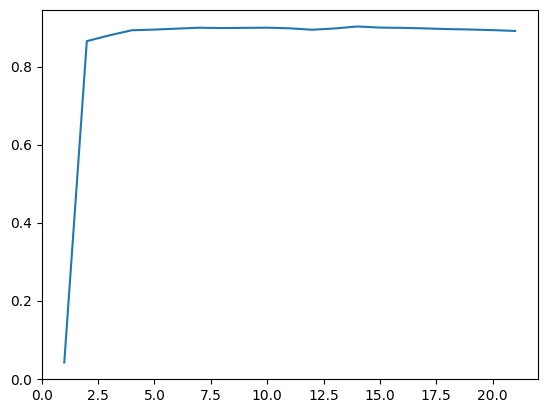

In [47]:
def get_accuracy_report():
    pass
plt.plot(range(1,22),accuracy_for_all_epochs)

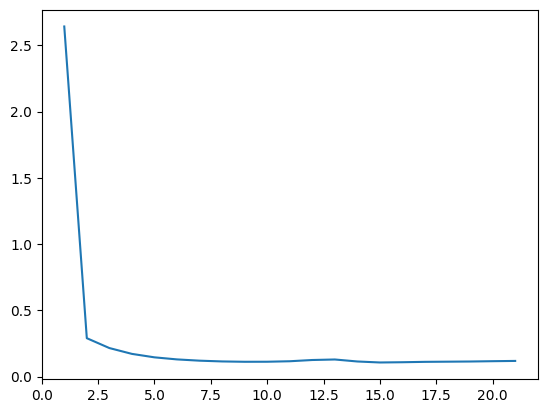

In [48]:
plt.plot(range(1,22),losses_for_all_epochs)